In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, Matern
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import norm
import scipy
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from scipy.stats import kurtosis

import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import FigureLayout,mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

from itertools import groupby
from operator import itemgetter


In [2]:
dfres = pd.read_hdf('/home/gorilla/An/data/WindyMASigned.h5') ## High Res

### Calculating where whiff initation happened on high res data

In [3]:
index = osc.get_index(dfres.odor,4)
whiff_initiation_points = [sub[0] for sub in index]
dfres['whiff_flag'] = 0

# Set 1 for the specified indices in the 'whiff_flag' column
dfres.iloc[whiff_initiation_points, dfres.columns.get_loc('whiff_flag')] = 1

dfres['distance_along_streakline']=dfres.distance_along_streakline*dfres.xsign
dfres['nearest_from_streakline']=dfres.nearest_from_streakline*dfres.ysign

### Calculating Whiff statistics

In [4]:
def avg_distance(df,index,dat): #input ; location ; storage
    i = 0
    distance_along_streakline = []
    nearest_from_streakline = []
    while i<len(index):
        distance_along_streakline.append(np.mean(df.distance_along_streakline[index[i]]))
        nearest_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
        i+=1
    dat['avg_distance_along_streakline']= distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def get_index_nowhiff(data, th):
    idx = [i for i, value in enumerate(data) if value < th]
    index = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(idx), lambda ix: ix[0] - ix[1])]
    return index

def avg_distance_nowhiff(df, idx, dat):
    distance_along_streakline = []
    nearest_from_streakline = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            distance_along_streakline.append(np.mean(df['distance_along_streakline'].iloc[indices]))
            nearest_from_streakline.append(np.mean(df['nearest_from_streakline'].iloc[indices]))
        else:
            distance_along_streakline.append(np.nan)
            nearest_from_streakline.append(np.nan)

    dat['avg_distance_along_streakline'] = distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def wc_wsd_nowhiff(df, idx, dat):
    wc_nowhiff = []
    std_dev_nowhiff = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            wc_nowhiff.append(np.mean(df['odor'].iloc[indices]))
            std_dev_nowhiff.append(np.std(df['odor'].iloc[indices]))
        else:
            wc_nowhiff.append(np.nan)
            std_dev_nowhiff.append(np.nan)

    dat['wc_nowhiff'] = wc_nowhiff
    dat['wsd_nowhiff'] = std_dev_nowhiff

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

th = 4
np.seterr(divide='ignore')
index = osc.get_index(dfres.odor,th)
index_nowhiff = get_index_nowhiff(dfres.odor,th)
fdf = pd.DataFrame()
fdf_nowhiff=pd.DataFrame()

cal_stat(dfres,index,fdf)
avg_distance(dfres, index, fdf)
wc_wsd_nowhiff(dfres, index_nowhiff,fdf_nowhiff)
avg_distance_nowhiff(dfres,index_nowhiff,fdf_nowhiff)

# fdf.keys()

#### P(Whiff Initiation) from highres data

Text(0.5, 1.0, 'Probability of Whiff Initiation - Actual Odor')

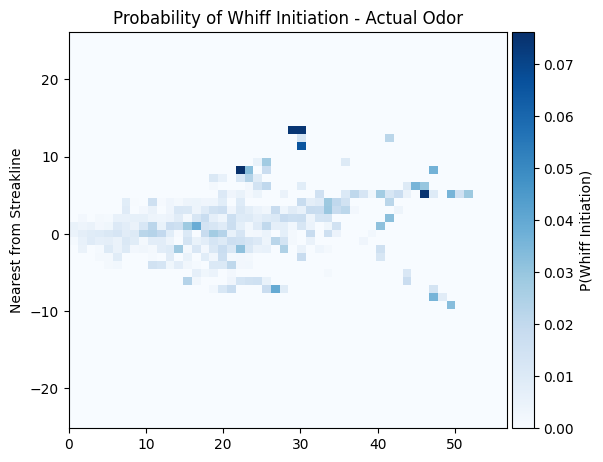

In [5]:
n_bins_x=n_bins_y=50
heatmap_whiff, xedges, yedges = np.histogram2d(dfres['distance_along_streakline'], 
                                               dfres['nearest_from_streakline'], 
                                               bins=[n_bins_x, n_bins_y], 
                                               weights=dfres['whiff_flag'])

# Histogram for total data points (irrespective of whiff initiation)
heatmap_total, _, _ = np.histogram2d(dfres['distance_along_streakline'], 
                                     dfres['nearest_from_streakline'], 
                                     bins=[n_bins_x, n_bins_y])

# Calculate the probability as number of whiff initiation points / total number of data points
with np.errstate(divide='ignore', invalid='ignore'):  # Handle division by zero
    heatmap_prob = np.divide(heatmap_whiff, heatmap_total, out=np.zeros_like(heatmap_whiff), where=heatmap_total != 0)

# Apply smoothing and normalization
# smoothed_heatmap_prob = smooth_heatmap(heatmap_prob, weight=0.2)
# smoothed_prob = normalize_probabilities(smoothed_heatmap_prob)

# Plot the original and smoothed heatmaps
f, (ax1) = plt.subplots(1, 1, figsize=(6, 8))

# Plot original heatmap (number of whiff initiation points / total data points)
cax1 = ax1.imshow(heatmap_prob.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Blues')
divider1 = make_axes_locatable(ax1)
cbar_ax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax1, cax=cbar_ax1, label='P(Whiff Initiation)')
ax1.set_ylabel('Nearest from Streakline')
ax1.set_title('Probability of Whiff Initiation - Actual Odor')


#### Likelihood of Estimation of probability - Gaussian Prob + Real world - 

Optimal Parameters:
A = 0.015440812476984683
x0 = 0.0
y0 = 0.0
sigma_x = 21.706226196705753
sigma_y = 0.460846558485007
theta = 3.122688198110767


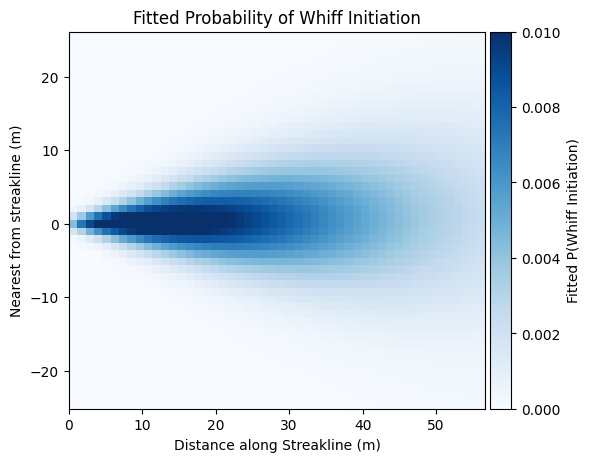

In [6]:
def directional_gaussian_plume(x, y, A, x0, y0, base_sigma_x, base_sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y, damping_factor):
    """Calculate a directional Gaussian plume model with dynamic spread."""
    distance_from_source = np.sqrt((x - x0)**2 + (y - y0)**2)
    # sigma_x = base_sigma_x + distance_scale_factor_x * distance_from_source
    # sigma_x = base_sigma_x + distance_scale_factor_x * np.log1p(distance_from_source)  # Logarithmic scale for less impact near source
    # sigma_y = base_sigma_y + distance_scale_factor_y * distance_from_source

    sigma_x = base_sigma_x + distance_scale_factor_x * np.sqrt(distance_from_source)
    sigma_y = base_sigma_y + distance_scale_factor_y * distance_from_source 
    
    xp = np.cos(theta) * (x - x0) - np.sin(theta) * (y - y0)
    yp = np.sin(theta) * (x - x0) + np.cos(theta) * (y - y0)

    p = A * np.exp(-((xp)**2 / (2 * sigma_x**2)) - ((yp)**2 / (2 * sigma_y**2))) * np.exp(-damping_factor / (distance_from_source + 1))
    
    # Clip the probabilities to avoid extreme values
    # p = np.clip(p, 0.01, 0.99) 

    return p

    # return A * np.exp(-((xp)**2 / (2 * sigma_x**2)) - ((yp)**2 / (2 * sigma_y**2)))
# Prepare bin centers (same as before)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers, indexing='ij')

# Flatten arrays
X_flat = X_centers.flatten()
Y_flat = Y_centers.flatten()
k_obs = heatmap_whiff.flatten()
n_obs = heatmap_total.flatten()

# Exclude bins with zero observations
valid_bins = n_obs > 0
X_flat = X_flat[valid_bins]
Y_flat = Y_flat[valid_bins]
k_obs = k_obs[valid_bins]
n_obs = n_obs[valid_bins]


def negative_log_likelihood(params, x, y, k, n):
    A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y,damping_factor = params
    p = directional_gaussian_plume(x, y, A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y,damping_factor)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1 - epsilon)
    ll = k * np.log(p) + (n - k) * np.log(1 - p)
    return -np.sum(ll)


# initial_params = [1.0, 0.0, 0.0, 50, 5, 0.0, 0.01, 0.1] # A, x0, y0, sigma_x, sigma_y, theta, dist_scale_x, dist_scale_y
initial_params = [1.0, 0.0, 0.0, 30, 3, 0.0, 0.6, 0.3, 0.8] # A, x0, y0, sigma_x, sigma_y, theta, dist_scale_x, dist_scale_y

# Bounds as discussed
bounds = [
    (0, 1),    # A ≥ 0
    (0, 0), # x0 unbounded
    (0, 0), # y0 unbounded
    (1e-5, None), # sigma_x ≥ 1e-5
    (1e-5, None), # sigma_y ≥ 1e-5
    (0, np.pi),  # theta ∈ [-π, π]
    (0,1),
    (0,1),
    (0.5,2)
]

# Perform the optimization
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(X_flat, Y_flat, k_obs, n_obs),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract optimal parameters
optimal_params = result.x
print("Optimal Parameters:")
print(f"A = {optimal_params[0]}")
print(f"x0 = {optimal_params[1]}")
print(f"y0 = {optimal_params[2]}")
print(f"sigma_x = {optimal_params[3]}")
print(f"sigma_y = {optimal_params[4]}")
print(f"theta = {optimal_params[5]}")

# Compute fitted probabilities50
fitted_p = directional_gaussian_plume(
    X_centers, Y_centers, *optimal_params
)
fitted_p_heatmap = fitted_p.reshape((len(x_centers), len(y_centers)))

# Plotting
f,ax=plt.subplots(1,1,figsize=(6, 6))
cax =ax.imshow(
    fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues', vmin=0,vmax=0.01
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='Fitted P(Whiff Initiation)')
ax.set_xlabel('Distance along Streakline (m)')
ax.set_ylabel('Nearest from streakline (m)')
ax.set_title('Fitted Probability of Whiff Initiation')

f.tight_layout()

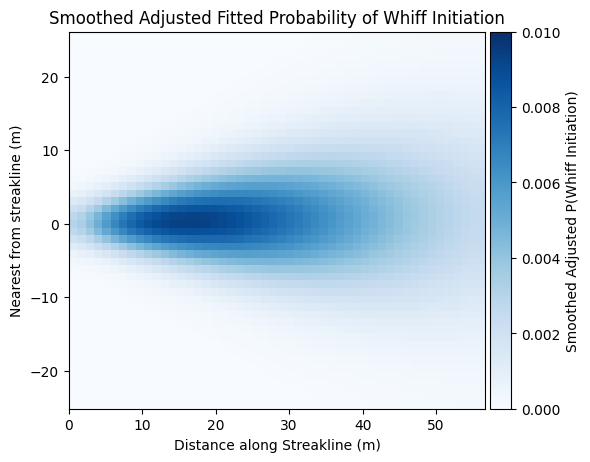

In [7]:
from scipy.ndimage import gaussian_filter

def smooth_heatmap_adjustment(heatmap, region_mask, adjustment_factor, sigma=1.0):
    # Apply the adjustment to the specified region
    adjusted_heatmap = heatmap.copy()
    adjusted_heatmap[region_mask] *= adjustment_factor
    smoothed_heatmap = gaussian_filter(adjusted_heatmap, sigma=sigma)
    
    return smoothed_heatmap

region_mask = (X_centers > 10) & (X_centers < 15)  # Adjust region between 10m and 15m along the streakline
adjustment_factor = 1  # Reduce probability by 20% in this region
sigma_smoothing = 2.0  # Gaussian smoothing standard deviation

# Smoothly adjust the fitted probability heatmap
smoothed_fitted_p_heatmap = smooth_heatmap_adjustment(fitted_p_heatmap, region_mask, adjustment_factor, sigma=sigma_smoothing)

# Plot the smoothed adjusted heatmap
f, ax = plt.subplots(1, 1, figsize=(6, 6))
cax = ax.imshow(
    smoothed_fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues', vmin=0, vmax=0.01
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='Smoothed Adjusted P(Whiff Initiation)')
ax.set_xlabel('Distance along Streakline (m)')
ax.set_ylabel('Nearest from streakline (m)')
ax.set_title('Smoothed Adjusted Fitted Probability of Whiff Initiation')

f.tight_layout()




#### Prep test data

In [8]:
df_test=dfres[10000:]
df_test.reset_index(inplace=True, drop=True)
dt=df_test.master_time[1]-df_test.master_time[0]
time = []
time.append(0)
for i in range(1,len(df_test)):
    time.append(time[i-1]+dt)
    
df_test['time'] = time


def predict_whiff_from_probability(x, y, hmap, xedges, yedges):
    x_bin = np.digitize(x, xedges) - 1  # -1 because digitize returns 1-based index
    y_bin = np.digitize(y, yedges) - 1

    if x_bin < 0 or x_bin >= hmap.shape[0] or y_bin < 0 or y_bin >= hmap.shape[1]:
        return False, 0  # No valid bin, so no whiff predicted, probability is 0
    whiff_prob = hmap[x_bin, y_bin]
    whiff_predicted = np.random.rand() < whiff_prob  # True if random number is less than the probability

    return whiff_predicted, whiff_prob

/tmp/ipykernel_1344841/3682713667.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['time'] = time


In [11]:
df_test.to_hdf('../data/simulator/hws/hwsDesert.h5', key='df', mode='w')

#### Extract Statistics from data

In [9]:
distance_threshold = 4
rows_per_second = 200
base_odor_level = 0.58 

odor_concentration_samples = np.full(len(df_test), base_odor_level)
whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values

whiff_means = fdf.mean_concentration.values
whiff_stds = fdf.std_whiff.values
whiff_duration = fdf.length_of_encounter.values
nowhiff_means = fdf_nowhiff.wc_nowhiff.values
nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values

In [25]:
distances = cdist(test_locations, whiff_locations)
distances_nowhiff = cdist(test_locations,nowhiff_locations )

In [26]:
fitted_p_heatmap_1=smoothed_fitted_p_heatmap
# dirname = '../data/simulator/'
# heatmap_file = np.load(str(dirname) + "hws.npy")
# fitted_p_heatmap_1 =np.load(str(dirname) + "hws.npy")

In [27]:
# np.savez('/home/gorilla/An/data/simulator/hws_hmap_with_edges.npz', fitted_p_heatmap=fitted_p_heatmap_1, xedges=xedges, yedges=yedges)

In [28]:
def moving_average(data, window_size):
    if window_size < 1 or len(data) < window_size:
        return data  # Return data as is if the window size is too large for the data length
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

i = 0
while i < len(df_test):
    dist_along, nearest_from = df_test.iloc[i][['distance_along_streakline', 'nearest_from_streakline']]
    whiff_predicted, whiff_prob = predict_whiff_from_probability(dist_along, nearest_from, 
                                                                 fitted_p_heatmap_1, xedges, yedges)
    # whiff_predicted, whiff_prob = predict_whiff_from_probability(dist_along, nearest_from, interpolator)
    
    if whiff_predicted and np.min(distances[i]) <= distance_threshold:
        nearest_whiff_idx = np.argmin(distances[i])
        mean_concentration = whiff_means[nearest_whiff_idx]
        std_dev_whiff = whiff_stds[nearest_whiff_idx]
        duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
        rows_to_fill = min(duration, len(df_test) - i)

        generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
        generated_concentrations = np.clip(generated_concentrations, 4, 10.2)
        odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
        whiff_prediction_samples[i:i + rows_to_fill] = 1
        i += rows_to_fill  # Move index by the number of filled rows
    else:
        i += 1  

# Step 2: Address No Whiff Regions
i = 0
while i < len(df_test):
    if odor_concentration_samples[i] == base_odor_level:
        nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
        no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
        no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]

        start = i
        while i < len(df_test) and odor_concentration_samples[i] == base_odor_level:
            i += 1
        end = i

        no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
        no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)  # Ensure values are within realistic bounds
        # odor_concentration_samples[start:end] = no_whiff_concentrations
        # Apply moving average smoothing
        smoothed_concentrations = moving_average(no_whiff_concentrations, window_size=5)

        odor_concentration_samples[start:end] = smoothed_concentrations
    else:
        i += 1

# Update the DataFrame with the results
df_test['predicted_odor'] = odor_concentration_samples
df_test['whiff_predicted'] = whiff_prediction_samples

/tmp/ipykernel_1093309/687032653.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_odor'] = odor_concentration_samples
/tmp/ipykernel_1093309/687032653.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['whiff_predicted'] = whiff_prediction_samples


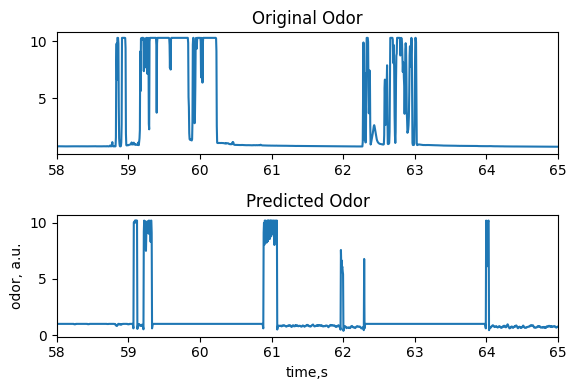

In [29]:
f,(ax1,ax2)= plt.subplots(2,1,figsize=(6,4))
ax1.plot(df_test.time, df_test.odor, label='original')
# plt.plot(df_test.smoothed_odor, label='smoothed')
ax2.plot(df_test.time, df_test.predicted_odor, label='predicted')
# ax2.axhline(4, color = 'r', linestyle = '--')

# limit=(1100,1120)
limit = (58,65)
ax1.set_xlim(limit)
ax2.set_xlim(limit)
# ax2.set_ylim(0,1)

ax2.set_ylabel('odor, a.u.')
ax2.set_xlabel('time,s')
ax1.set_title('Original Odor')
ax2.set_title('Predicted Odor')
f.tight_layout()

In [30]:
th=4.5
query1 = 'odor>4.5'
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>4.5'
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)

In [31]:
# df_test.to_hdf('/home/gorilla/An/data/Oct29Plumes/train_raw/hws.h5', key='df',mode='w')

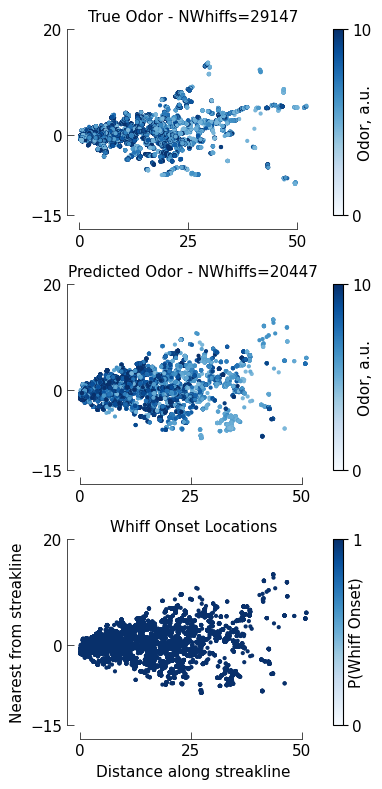

In [32]:
f, ax = plt.subplots(3, 1, figsize=(4, 8))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax3 = ax[2].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.whiff_predicted, s = 4, cmap='Blues', vmin=0, vmax=1)


# ylim=(-15,25)

ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))
ax[2].set_title('Whiff Onset Locations')
ax[2].set_xlabel('Distance along streakline')
ax[2].set_ylabel('Nearest from streakline')

cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)
cb3=plt.colorbar(cax3)

cb1.set_label('Odor, a.u.',labelpad=-10)
cb2.set_label('Odor, a.u.',labelpad=-10)
cb3.set_label('P(Whiff Onset)',labelpad=-10)

cb1.set_ticks([0,10])
cb2.set_ticks([0,10])
cb3.set_ticks([0, 1])
for i in range(3):
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,25,50],
                            yticks=[-15,0,20],
                            linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],11)

f.tight_layout()

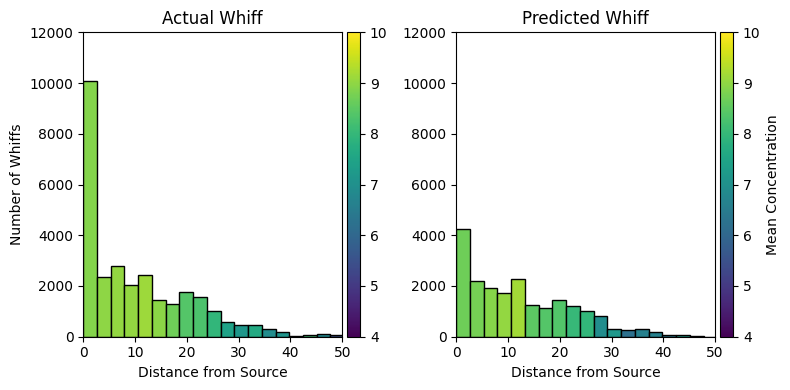

In [33]:
n_bins = 20

# Actual Whiff Data
df_actual = new_test_df1.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Predicted Whiff Data
df_predicted = new_test_df2.copy()
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# Create the subplots
f, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot for Actual Whiff Data
norm_actual = plt.Normalize(4, 10)
colors_actual = plt.cm.viridis(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='viridis', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)
# cbar_actual.set_label('Mean Concentration')

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('Number of Whiffs')
ax[0].set_title('Actual Whiff')
ax[0].set_ylim(0,12000)
ax[0].set_xlim(0,50)
# Plot for Predicted Whiff Data
norm_predicted = plt.Normalize(4, 10)
colors_predicted = plt.cm.viridis(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='viridis', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_title('Predicted Whiff')
ax[1].set_ylim(0,12000)
ax[1].set_xlim(0,50)
f.tight_layout()



In [17]:
new_test_df=df_test.copy()

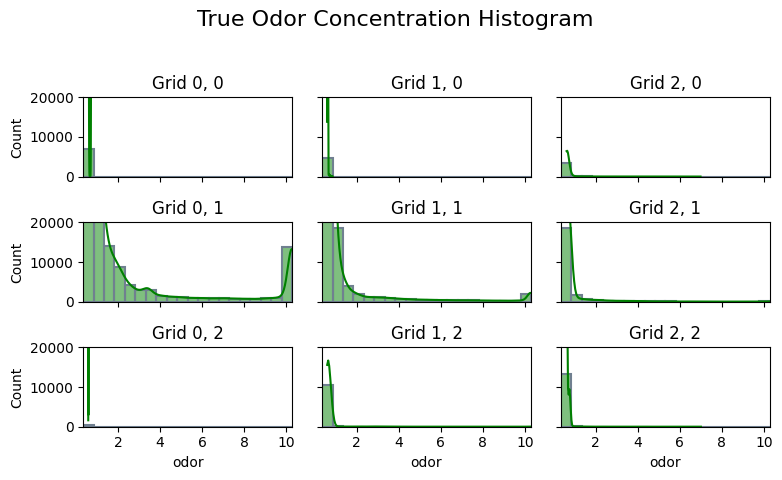

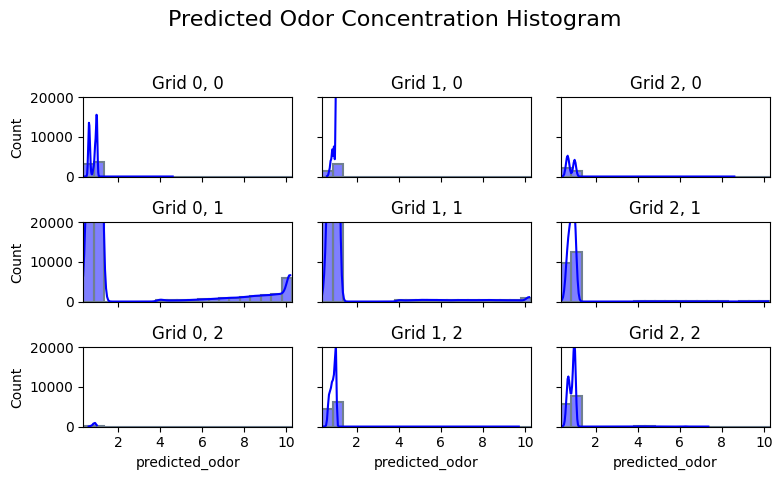

In [54]:
# new_test_df=df_test.copy()
n_bins_x = 3
n_bins_y = 3
n_bins_hist = 20

x_bin_edges = np.linspace(new_test_df['distance_along_streakline'].min(), new_test_df['distance_along_streakline'].max(), n_bins_x + 1)
y_bin_edges = np.linspace(new_test_df['nearest_from_streakline'].min(), new_test_df['nearest_from_streakline'].max(), n_bins_y + 1)

new_test_df['x_bin'] = pd.cut(new_test_df['distance_along_streakline'], bins=x_bin_edges, labels=False)
new_test_df['y_bin'] = pd.cut(new_test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False)
# Determine global range for histogram bins
global_min = new_test_df[['odor', 'predicted_odor']].min().min()
global_max = new_test_df[['odor', 'predicted_odor']].max().max()
bin_edges = np.linspace(global_min, global_max, n_bins_hist + 1)

# Define specific x-axis limitsdf_test
specific_x_min = global_min
specific_x_max = global_max
ylim=[0,20000]
# Plot histograms for true odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['odor']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='green', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actualdf_test data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('True Odor Concentration Histogram', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot histograms for corrected true odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['predicted_odor']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='blue', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actual data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('Predicted Odor Concentration Histogram', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


In [19]:
new_test_df1=df_test.copy()
new_test_df2=df_test.copy()

In [20]:
def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df1.odor,th)
index_predicted = osc.get_index(new_test_df2.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df1,index,fdf1)
cal_stat_predicted(new_test_df2,index_predicted, fdf_predicted)

fdf1.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

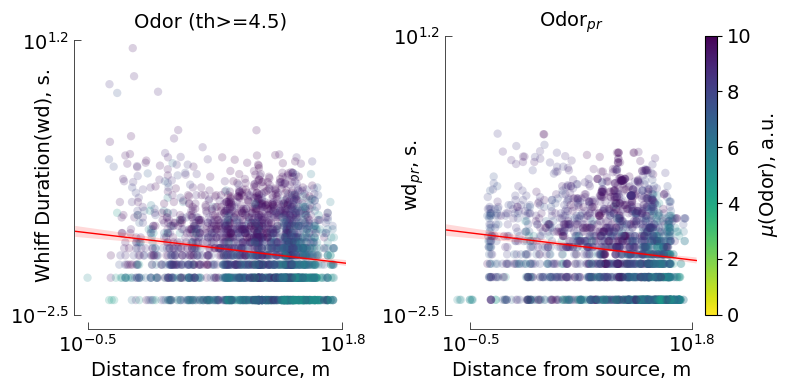

In [ ]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf1.log_avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2,vmin=0,vmax=10  )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source,y=fdf1.log_whiff , data=fdf1,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source, m')
ax1.set_ylabel('Whiff Duration(wd), s.')
ax1.set_title('Odor (th>='+str(th)+')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

u=ax2.scatter(fdf_predicted.log_avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2, vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(Odor), a.u.')

ax2.set_xlabel('Distance from source, m')
ax2.set_title('Odor$_{pr}$')
ax2.set_ylabel('wd$_{pr}$, s.')
ax2.yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[-0.5,1.8],
                            yticks=[-2.5,1.2],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[-0.5,1.8],
                            yticks=[-2.5,1.2],
                            linewidth=0.5)
ax1.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.2}$'])
ax1.set_xticklabels([r'$10^{-0.5}$',r'$10^{1.8}$'])
ax2.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.2}$'])
ax2.set_xticklabels([r'$10^{-0.5}$',r'$10^{1.8}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout()


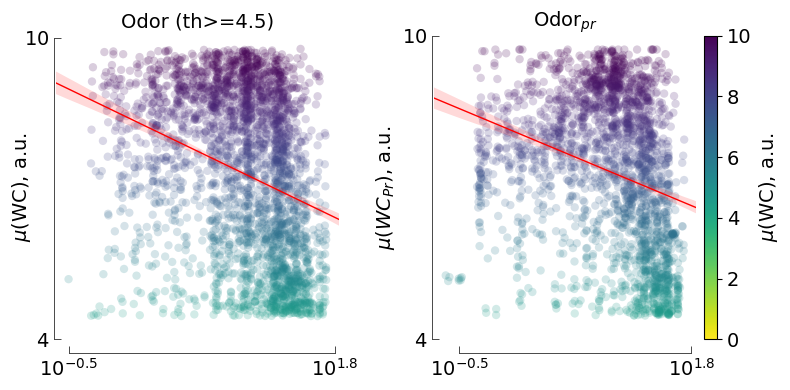

In [49]:
### Whiff concentration
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var1 = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                   alpha=0.2, vmin=0, vmax=10)


g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.mean_concentration, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar = f.colorbar(var1, cax=cax, orientation='vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

# ax1.set_xlabel('Distance from source (log), m')
ax1.set_title('Odor (th>=' + str(th) + ')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

# Plot for predicted odor
var2 = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, c=fdf_predicted.mean_concentration,
                   cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.mean_concentration, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# ax2.set_xlabel('Distance from source (log), m')
ax2.set_title('Odor$_{pr}$')
ax1.set_ylabel('$\mu$(WC), a.u.')
ax2.set_ylabel('$\mu(WC_{Pr})$, a.u.')
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.5, 1.8],
                            yticks=[4, 10.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.5, 1.8],
                            yticks=[4, 10.5],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$4$', r'$10$'])
ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$4$', r'$10$'])
ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


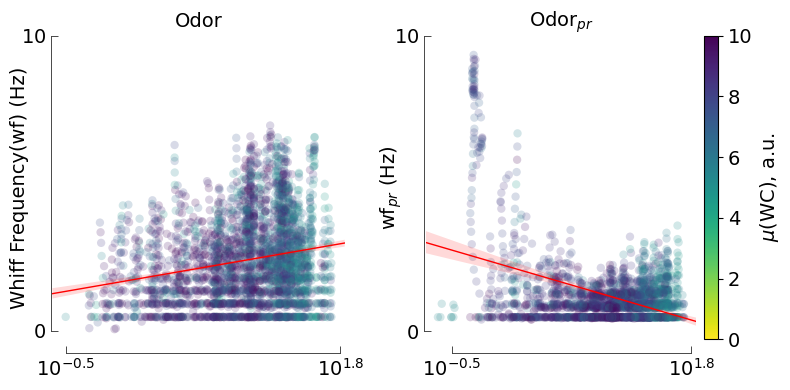

In [ ]:
### WHIFF FREQUENCY
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.wf, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Frequency (Hz)')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.wf, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)
ax1.set_title('Odor')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.wf, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
ax2.set_title('Odor$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
ax1.set_ylabel('Whiff Frequency(wf) (Hz)')
ax2.set_ylabel('wf$_{pr}$ (Hz)')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.5, 1.8],
                            yticks=[0, 10.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.5, 1.8],
                            yticks=[0, 10.5],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

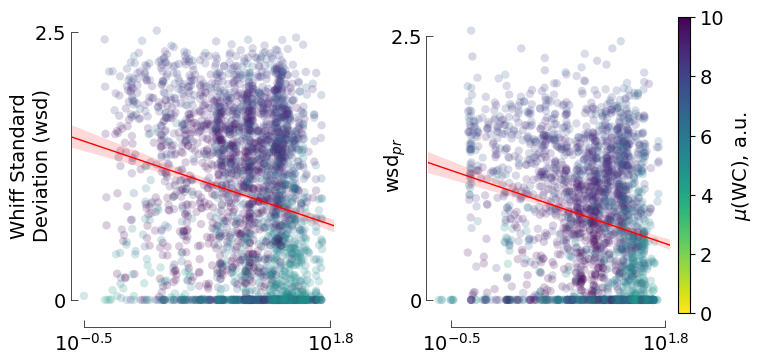

In [47]:
### WHIFF STANDARD DEVIATION
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.std_whiff, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.std_whiff, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# Remove color bar for the actual odor plot
# ax1.set_xlabel('Distance from source (log), m')
# ax1.set_title('Actual Odor (th>=' + str(th) + ')')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.std_whiff, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.std_whiff, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
# ax2.set_title('Predicted Odor')
ax1.set_ylabel('Whiff Standard\nDeviation (wsd)')
ax2.set_ylabel('wsd$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.5, 1.8],
                            yticks=[0, 2.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.5, 1.8],
                            yticks=[0, 2.5],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$2.5$'])
ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$0$', r'$2.5$'])
ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout(pad=2)


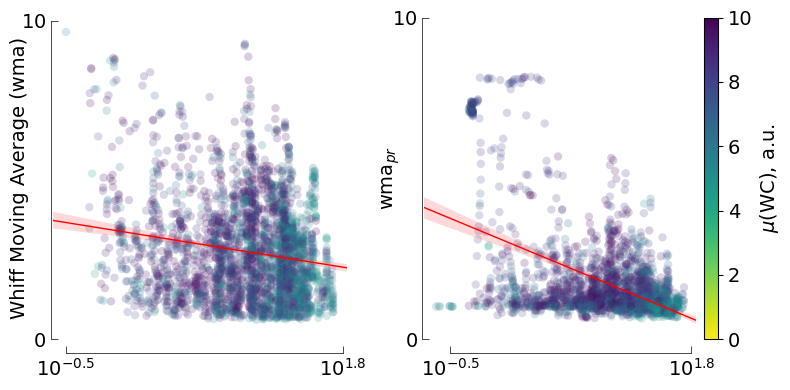

In [45]:
### WHIFF MOVING AVERAGE
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.whiff_ma, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Moving Average (wma)')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.whiff_ma, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# Remove color bar for the actual odor plot
# ax1.set_xlabel('Distance from source (log), m')
# ax1.set_title('Actual Odor (th>=' + str(th) + ')')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.whiff_ma, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.whiff_ma, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
# ax2.set_title('Predicted Odor')
ax1.set_ylabel('Whiff Moving Average (wma)')
ax2.set_ylabel('wma$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.5, 1.8],
                            yticks=[0, 10.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.5, 1.8],
                            yticks=[0, 10],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


In [55]:
import statsmodels.formula.api as smf

def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 30), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 30, 'type'] = 2
    return dataframe

fdf_new = create_class_column(fdf1)
fdf_predicted_new = create_class_column(fdf_predicted)

In [56]:
lookback_time = 10
trainset = fdf_new

D_train = []
mean_time_train = []
Xtrain = []
ytrain = []
Nrows_train = []

# Loop through distance classes, using the modified functions
for distance_class in [0, 1, 2]:
    Xtrain, ytrain, D_train, Nrows_train, mean_time_train = osc.gather_stat_timed(
        trainset, distance_class, lookback_time, Xtrain, ytrain, D_train, Nrows_train, mean_time_train)

# Calculate statistical values
def calc_val(X):
    return np.ravel([np.min(X), np.max(X), np.mean(X), np.std(X), kurtosis(X)])

# Create a DataFrame to store the results
column_names = ['mc_min', 'mc_max', 'mc_mean', 'mc_std_dev', 'mc_k',
                'wf_min', 'wf_max', 'wf_mean', 'wf_std_dev', 'wf_k',
                'wd_min', 'wd_max', 'wd_mean', 'wd_std_dev', 'wd_k',
                'ma_min', 'ma_max', 'ma_mean', 'ma_std_dev', 'ma_k',
                'st_min', 'st_max', 'st_mean', 'st_std_dev', 'st_k']

traindf = pd.DataFrame(columns=column_names)
c1 = []

# Populate the DataFrame with the smoothed and consistent stats
for i in range(len(Xtrain)):
    if np.size(Xtrain[i]) == 0:
        c1.append(i)
        continue
    else:
        X = []
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i] = np.ravel(X)

# Add additional columns for distance, mean whiff time, and number of whiffs
traindf['distance'] = np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)

/tmp/ipykernel_722454/627185542.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X), np.max(X), np.mean(X), np.std(X), kurtosis(X)])
/tmp/ipykernel_722454/627185542.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X), np.max(X), np.mean(X), np.std(X), kurtosis(X)])
/tmp/ipykernel_722454/627185542.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X), np.max(X), np.mean(X), np.std(X), kurtosis(X)])
/tmp/ipykernel_722454/627185542.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. T

In [57]:
# distance=smf.ols(formula=""" distance ~ mc_mean + ma_std_dev + ma_max + wd_std_dev """, data=traindf).fit()
# print(distance.summary())

In [58]:
lookback_time = 10

trainset_predicted= fdf_predicted_new

D_train_predicted=[]
mean_time_train_predicted=[]
Xtrain_predicted = []
ytrain_predicted = []
predictions_filled = []
mean_time_train_predicted = []
Nrows_train_predicted = []

for distance_class in [0,1,2]:
    Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted , mean_time_train_predicted = osc.gather_stat_timed(trainset_predicted, distance_class,
                      lookback_time, Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted,
                      mean_time_train_predicted)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf_predicted=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain_predicted)):
    if(np.size(Xtrain_predicted[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain_predicted[i])):
            X.append(calc_val(Xtrain_predicted[i][j]))
        traindf_predicted.loc[i]=np.ravel(X)
        
traindf_predicted['distance']=np.delete(D_train_predicted, c1)
traindf_predicted['mean_whiff_time'] = np.delete(mean_time_train_predicted, c1)
traindf_predicted['nwhiffs'] = np.delete(Nrows_train_predicted, c1)

/tmp/ipykernel_722454/975394852.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_722454/975394852.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_722454/975394852.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_722454/975394852.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs w

In [63]:
# distance=smf.ols(formula=""" distance ~ mc_mean + ma_std_dev + ma_max + wd_std_dev """, data=traindf_predicted).fit()
# print(distance.summary())

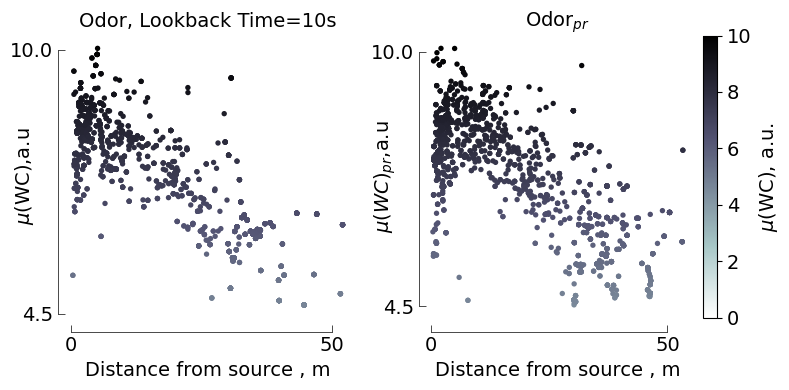

In [70]:
## whiff concentration
f,ax = plt.subplots(1,2,figsize=(8,4))
var1 =ax[0].scatter(traindf.distance, traindf.mc_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# divider = make_axes_locatable(ax[0])
# cax1 = divider.append_axes('right', size='5%', pad=0.08)
# cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
# cbar1.solids.set(alpha=1)
# cbar1.set_label('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
#             ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.mc_mean,c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)

cbar1.set_label('$\mu$(WC), a.u.')
# ax[1].set_ylabel('$\mu$(WC)_predicted, a.u.')
ax[0].set_ylabel('$\mu$(WC),a.u')
ax[1].set_ylabel('$\mu(WC)_{pr}$,a.u')
ax[0].set_xlabel('Distance from source , m')
ax[1].set_xlabel('Distance from source , m')

ax[0].set_title('Odor, Lookback Time=10s')
ax[1].set_title('Odor$_{pr}$')

mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[4.5, 10],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[4.5,10],
                            linewidth=0.5)
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[1].yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


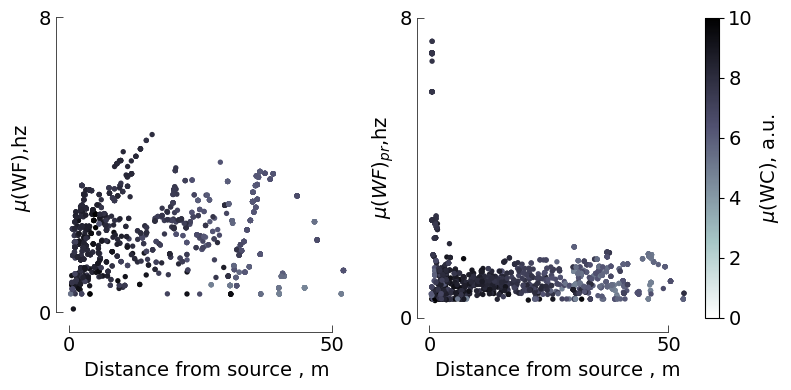

In [82]:
f,ax = plt.subplots(1,2,figsize=(8,4))
var1 =ax[0].scatter(traindf.distance, traindf.wf_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# divider = make_axes_locatable(ax[0])
# cax1 = divider.append_axes('right', size='5%', pad=0.08)
# cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
# cbar1.solids.set(alpha=1)
# cbar1.set_label('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
#             ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.wf_mean,c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)

cbar1.set_label('$\mu$(WC), a.u.')
# ax[1].set_ylabel('$\mu$(WC)_predicted, a.u.')
ax[0].set_ylabel('$\mu$(WF),hz')
ax[1].set_ylabel('$\mu(WF)_{pr}$,hz')
ax[0].set_xlabel('Distance from source , m')
ax[1].set_xlabel('Distance from source , m')

# ax[0].set_title('Odor, Lookback Time=10s')
# ax[1].set_title('Odor$_{pr}$')

mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[0,8],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[0,8],
                            linewidth=0.5)
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[1].yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

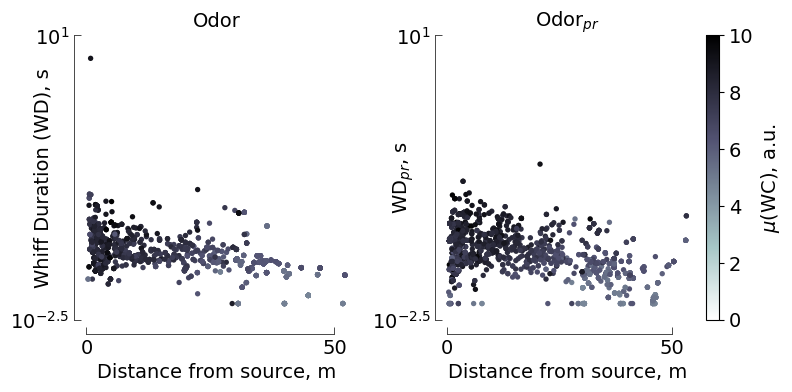

In [87]:
## WHIFF DURATION
f, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual whiff duration
var1 = ax[0].scatter(traindf.distance, traindf.wd_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Plot for predicted whiff duration
var2 = ax[1].scatter(traindf_predicted.distance, traindf_predicted.wd_mean, c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Add color bar for the predicted plot only
divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set labels and titles
ax[0].set_ylabel('Whiff Duration (WD), s')
ax[1].set_ylabel('WD$_{pr}$, s')
ax[0].set_xlabel('Distance from source, m')
ax[1].set_xlabel('Distance from source, m')
ax[0].set_title('Odor')
ax[1].set_title('Odor$_{pr}$')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[-2.5, 1.0],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[-2.5, 1.0],
                            linewidth=0.5)

# Adjust label positions
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[1].yaxis.set_label_coords(-0.08, 0.5)

ax[0].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])
# ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax[1].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])
# ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout(pad=1)


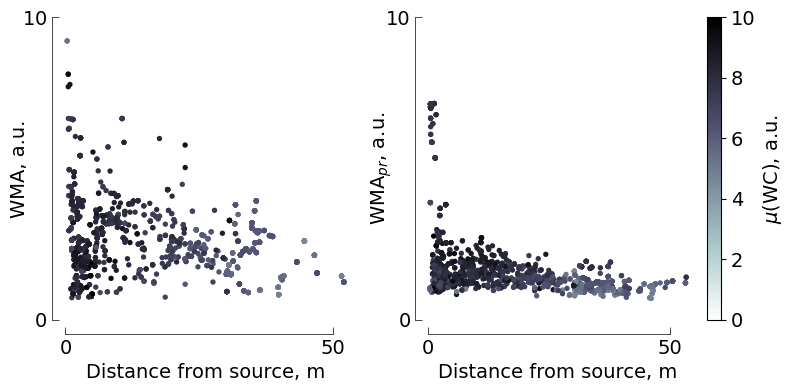

In [94]:
## WHIFF MOVING AVERAGE (WMA)
f, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual WMA
var1 = ax[0].scatter(traindf.distance, traindf.ma_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Plot for predicted WMA
var2 = ax[1].scatter(traindf_predicted.distance, traindf_predicted.ma_mean, c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Add color bar for the predicted plot only
divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set labels and titles
ax[0].set_ylabel('WMA, a.u.')
ax[1].set_ylabel('WMA$_{pr}$, a.u.')
ax[0].set_xlabel('Distance from source, m')
ax[1].set_xlabel('Distance from source, m')
# ax[0].set_title('Odor')
# ax[1].set_title('Odor$_{pr}$')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0,11],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0,10],
                            linewidth=0.5)

# Adjust label positions
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[1].yaxis.set_label_coords(-0.08, 0.5)
ax[0].set_yticklabels([r'$0$', r'$10$'])
# ax[0].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])
# ax[1].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout(pad=1)
plt.show()


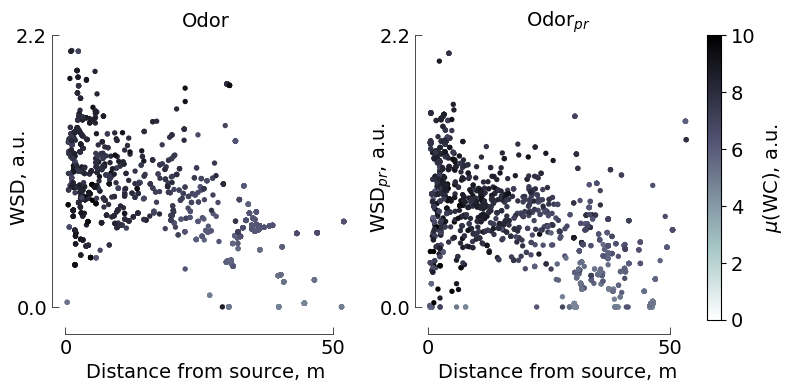

In [95]:
## WHIFF STANDARD DEVIATION (WSD)
f, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual WSD
var1 = ax[0].scatter(traindf.distance, traindf.st_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Plot for predicted WSD
var2 = ax[1].scatter(traindf_predicted.distance, traindf_predicted.st_mean, c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Add color bar for the predicted plot only
divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set labels and titles
ax[0].set_ylabel('WSD, a.u.')
ax[1].set_ylabel('WSD$_{pr}$, a.u.')
ax[0].set_xlabel('Distance from source, m')
ax[1].set_xlabel('Distance from source, m')
ax[0].set_title('Odor')
ax[1].set_title('Odor$_{pr}$')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0,2.2],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0,2.2],
                            linewidth=0.5)

# Adjust label positions
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[1].yaxis.set_label_coords(-0.08, 0.5)

# ax[0].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])
# ax[1].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout(pad=1)
plt.show()


In [ ]:
|